# AWS Greengrass Data Analysis Notebook
## Complete Pipeline from Athena Query to Visualization

In [65]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyathena import connect
from matplotlib.ticker import FuncFormatter

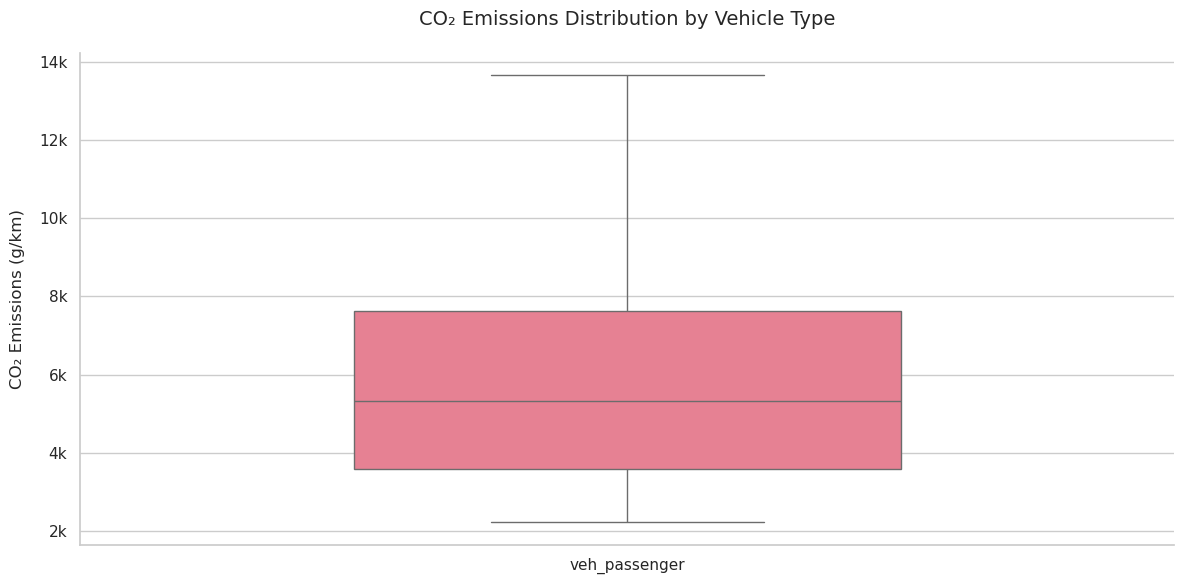

/tmp/ipykernel_23423/312248581.py:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


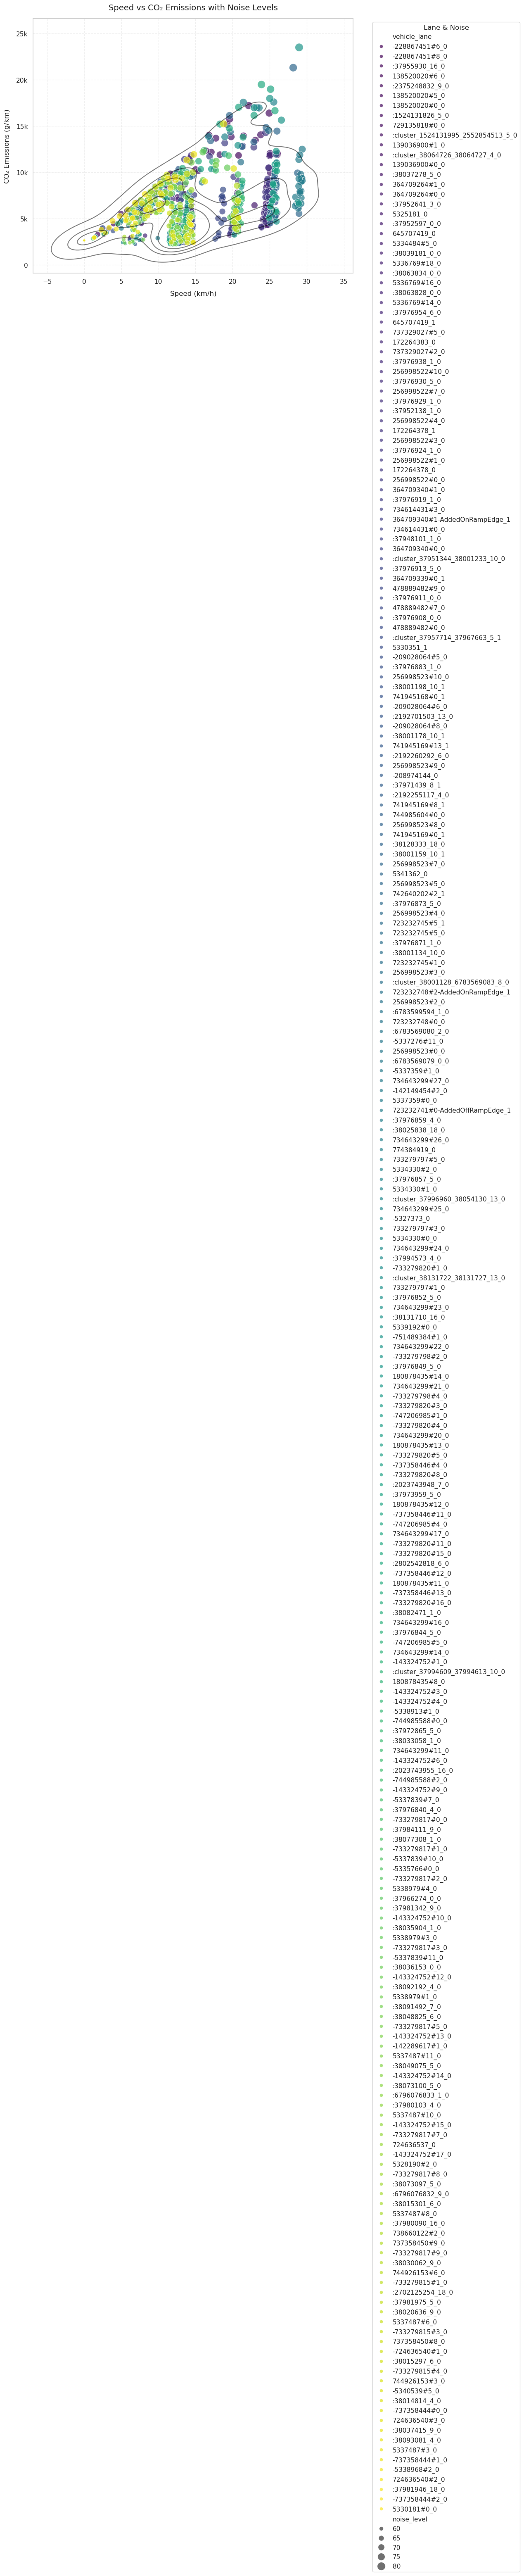

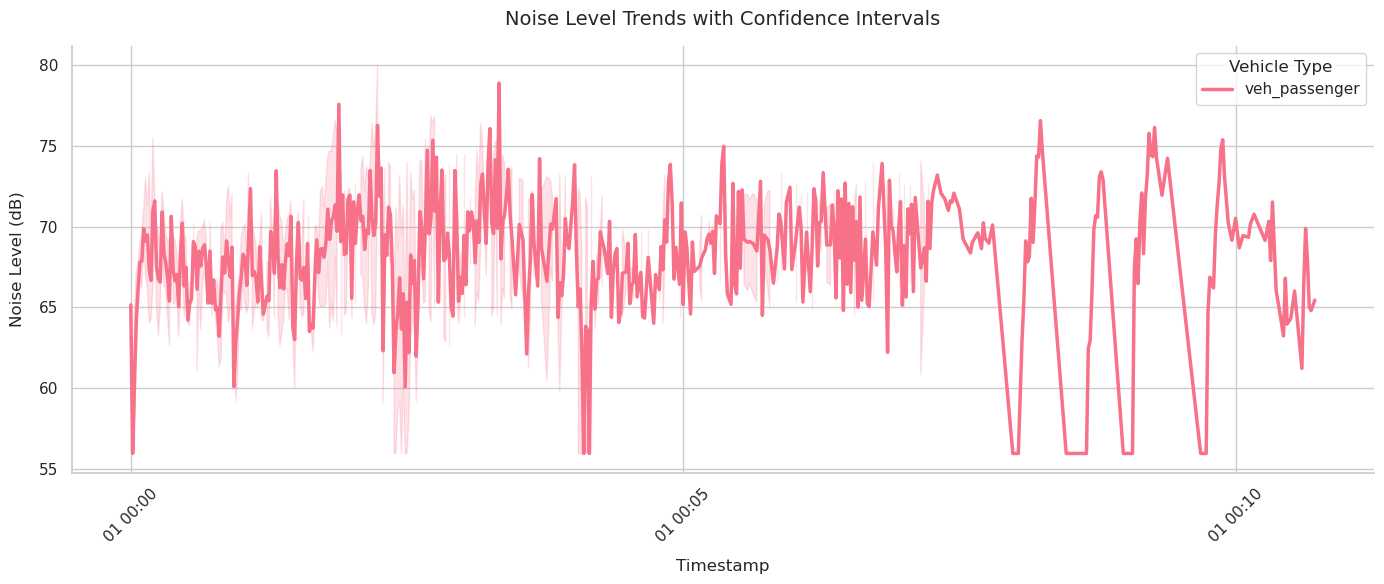

In [66]:
def load_vehicle_data():
    """Load complete vehicle telemetry data"""
    try:
        conn = connect(
            s3_staging_dir='s3://lab4data-tijis2/athena-results/',
            region_name='us-east-1',
            schema_name='greengrass_db'
        )
        
        query = """
        SELECT 
            vehicle_id,
            vehicle_type,
            CAST(timestep_time AS DOUBLE) as timestamp,
            CAST(vehicle_co2 AS DOUBLE) as co2,
            CAST(vehicle_co AS DOUBLE) as co,
            CAST(vehicle_nox AS DOUBLE) as nox,
            CAST(vehicle_speed AS DOUBLE) as speed,
            CAST(vehicle_noise AS DOUBLE) as noise,
            CAST(vehicle_fuel AS DOUBLE) as fuel_consumption,
            vehicle_lane
        FROM greengrass_db.lab4data_tijis2
        WHERE vehicle_co2 > 0
        ORDER BY timestamp DESC
        LIMIT 1000
        """
        
        cursor = conn.cursor()
        cursor.execute(query)
        df = pd.DataFrame(
            cursor.fetchall(),
            columns=[desc[0] for desc in cursor.description]
        )
        
        # Convert timestamp to datetime and extract hour
        df['time'] = pd.to_datetime(df['timestamp'], unit='s')
        df['hour'] = df['time'].dt.hour
        
        return df
        
    except Exception as e:
        print(f"Data loading failed: {str(e)}")
        return pd.DataFrame()
    finally:
        if 'cursor' in locals(): cursor.close()
        if 'conn' in locals(): conn.close()

# Load data
vehicle_data = load_vehicle_data()

if not vehicle_data.empty:
    # Set style
    sns.set_style("whitegrid")
    plt.rcParams['figure.facecolor'] = 'white'
    
    # 1. Simplified Emission Comparison
    plt.figure(figsize=(10, 6))
    sns.barplot(
        data=vehicle_data,
        x='vehicle_type',
        y='co2',
        estimator='median',
        errorbar=None,
        palette='Blues_d'
    )
    plt.title('Median CO₂ Emissions by Vehicle Type', pad=15)
    plt.ylabel('CO₂ (g/km)')
    plt.xlabel('')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # 2. Combined Emission Scatterplot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(
        data=vehicle_data,
        x='speed',
        y='co2',
        hue='fuel_consumption',
        size='noise',
        palette='viridis',
        alpha=0.7
    )
    plt.title('Speed vs CO₂ (Colored by Fuel Consumption)', pad=15)
    plt.xlabel('Speed (km/h)')
    plt.ylabel('CO₂ (g/km)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # 3. Hourly Emission Patterns
    plt.figure(figsize=(12, 6))
    sns.lineplot(
        data=vehicle_data,
        x='hour',
        y='co2',
        hue='vehicle_type',
        estimator='mean',
        errorbar=None,
        linewidth=2
    )
    plt.title('Hourly CO₂ Emission Patterns', pad=15)
    plt.xlabel('Hour of Day')
    plt.ylabel('Average CO₂ (g/km)')
    plt.xticks(range(24))
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(title='Vehicle Type')
    plt.tight_layout()
    plt.show()
    
    # 4. Pollution Correlation Matrix
    plt.figure(figsize=(8, 6))
    corr = vehicle_data[['co2', 'co', 'nox', 'speed', 'noise', 'fuel_consumption']].corr()
    sns.heatmap(
        corr,
        annot=True,
        fmt=".2f",
        cmap='coolwarm',
        vmin=-1,
        vmax=1,
        linewidths=0.5
    )
    plt.title('Pollution Factor Correlations', pad=15)
    plt.tight_layout()
    plt.show()
    
else:
    print("No data loaded - check error messages")